# Elementary Recipe for Quantum Circuit Unoptimization

Code that implements the elementary recipe from "Quantum Circuit Unoptimization" ([arXiv:2311.03805](https://arxiv.org/pdf/2311.03805)).

## Preliminaries

In [2]:
import numpy as np
import random

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import random_unitary, Operator

First, we need a way of generating a random circuit consisting of two-qubit gates.

In [3]:
def random_two_qubit_circuit(num_qubits: int, depth: int) -> QuantumCircuit:
    """Generate a random quantum circuit with two-qubit gates.

    Args:
        num_qubits: The number of qubits in the circuit.
        depth: The number of layers (depth) of two-qubit gates.

    Returns:
        The generated random circuit.
    """
    qc = QuantumCircuit(num_qubits)

    # Map gate names to their corresponding methods
    gate_map = {
        "cx": qc.cx,
        "cz": qc.cz,
        "swap": qc.swap,
        "iswap": qc.iswap
    }

    for _ in range(depth):
        qubit1, qubit2 = random.sample(range(num_qubits), 2)
        gate = random.choice(list(gate_map.keys()))
        gate_map[gate](qubit1, qubit2)

    return qc

As an example, here is randomly generated 5-qubit and depth-10 circuit consisting of two-qubit gates 

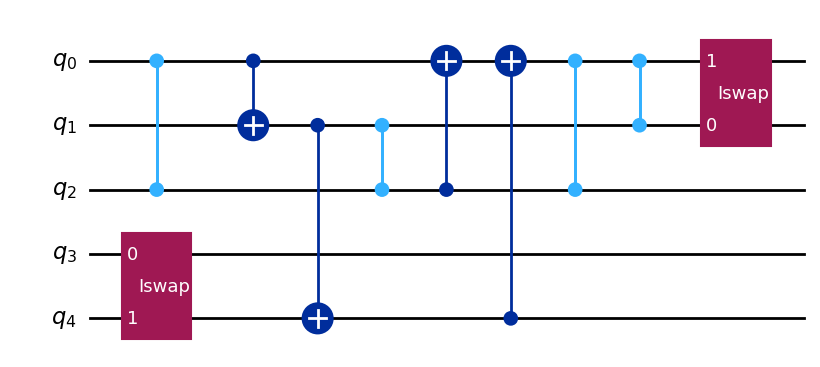

In [4]:
num_qubits = 5
depth = 10
random_circuit = random_two_qubit_circuit(num_qubits, depth)

random_circuit.draw("mpl")

## Elementary recipe

The elementary recipe (ER) for quantum circuit unoptimization is given by Figure-1 in [arXiv:2311.03805](https://arxiv.org/pdf/2311.03805). The ER contains the following steps (applied in the following order):

1. Gate insertion
2. Gate swapping
3. Gate decomposition
4. Gate synthesis

### Gate insertion

In [5]:
def gate_insert(qc: QuantumCircuit, strategy="P_r", previous_er_gates=None):
    """Insert a two-qubit gate A and its Hermitian conjugate A† between two gates B1 and B2.

    Args:
        qc: The input quantum circuit.
        strategy: The strategy used to select the pair of two-qubit gates ("P_r" or "P_c").
        previous_er_gates: List of gates generated in previous ER steps (used for "P_c").

    Returns:
        new_qc: The modified quantum circuit with A and A† inserted.
        B1_info: Information about gate B1 and the inserted gates.
        updated_er_gates: Updated list of gates generated in this ER.
    """
    # Collect all two-qubit gates with their indices and qubits
    two_qubit_gates = []
    for idx, instruction in enumerate(qc.data):
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        if len(qargs) == 2:
            qubit_indices = [qc.find_bit(qarg).index for qarg in qargs]
            two_qubit_gates.append({"index": idx, "qubits": qubit_indices, "gate": instr})

    # Initialize the list of gates generated in previous ERs if None
    if previous_er_gates is None:
        previous_er_gates = []

    found_pair = False

    if strategy == "P_r":
        # Randomly select a two-qubit gate as the target gate
        temp_gates = two_qubit_gates.copy()
        while not found_pair and temp_gates:
            target_gate = random.choice(temp_gates)
            target_idx = target_gate["index"]
            target_qubits = set(target_gate["qubits"])
            # Find candidate gates that share a common qubit with the target gate
            candidate_gates = []
            for gate in two_qubit_gates:
                if gate["index"] != target_idx:
                    qubits = set(gate["qubits"])
                    if len(target_qubits & qubits) == 1:
                        candidate_gates.append(gate)
            if candidate_gates:
                # Randomly select one candidate gate
                B1_gate_info = target_gate
                B2_gate_info = random.choice(candidate_gates)
                shared_qubit = list(target_qubits & set(B2_gate_info["qubits"]))[0]
                found_pair = True
            else:
                # Remove the target gate and try again
                temp_gates.remove(target_gate)
        if not found_pair:
            raise ValueError("No suitable pair of two-qubit gates found using P_r strategy.")

    elif strategy == "P_c":
        # If it's the first iteration, use P_r
        if not previous_er_gates:
            return gate_insert(qc, strategy="P_r", previous_er_gates=previous_er_gates)
        else:
            # Select a gate from previous ERs as one of the pair
            er_gate_indices = [gate_info["index"] for gate_info in previous_er_gates]
            candidate_pairs = []
            for gate in two_qubit_gates:
                if gate["index"] in er_gate_indices:
                    # Find gates that share a common qubit with this ER gate
                    target_qubits = set(gate["qubits"])
                    for other_gate in two_qubit_gates:
                        if (other_gate["index"] != gate["index"] and
                            other_gate["index"] not in er_gate_indices):
                            qubits = set(other_gate["qubits"])
                            if len(target_qubits & qubits) == 1:
                                candidate_pairs.append((gate, other_gate))
            if candidate_pairs:
                # Choose the rightmost pair (with the highest index sum)
                B1_gate_info, B2_gate_info = max(
                    candidate_pairs,
                    key=lambda pair: pair[0]["index"] + pair[1]["index"]
                )
                shared_qubit = list(
                    set(B1_gate_info["qubits"]) & set(B2_gate_info["qubits"])
                )[0]
                found_pair = True
            else:
                # No candidate found, revert to P_r
                return gate_insert(qc, strategy="P_r", previous_er_gates=previous_er_gates)
    else:
        raise ValueError('Invalid strategy specified. Use "P_r" or "P_c".')

    # Generate a random two-qubit unitary A and its adjoint A†
    A = random_unitary(4)
    A_dag = A.adjoint()

    # Choose qubits for A and A† insertion
    all_qubits = set(range(qc.num_qubits))
    involved_qubits = set(B1_gate_info["qubits"] + B2_gate_info["qubits"])
    other_qubits = list(all_qubits - involved_qubits)
    if not other_qubits:
        raise ValueError("Not enough qubits to perform the operation.")
    third_qubit = other_qubits[0]

    # Map indices back to qubits
    qubit_map = {qc.find_bit(q).index: q for q in qc.qubits}
    shared_qubit_obj = qubit_map[shared_qubit]

    # Create a new circuit and insert A and A†
    new_qc = QuantumCircuit(qc.num_qubits)

    # Copy the gates up to and including B1
    B1_idx = B1_gate_info["index"]
    for instruction in qc.data[:B1_idx+1]:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        new_qc.append(instr, qargs, cargs)

    # Insert A on qubits [shared_qubit, third_qubit]
    qubits_for_A = [shared_qubit_obj, qubit_map[third_qubit]]
    new_qc.unitary(A, qubits_for_A, label="A")

    # Insert A† on the same qubits
    new_qc.unitary(A_dag, qubits_for_A, label="A†")

    # Copy the remaining gates
    for instruction in qc.data[B1_idx+1:]:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        new_qc.append(instr, qargs, cargs)

    # Prepare B1_info for gate_swap function
    B1_info = {
        "index": B1_gate_info["index"],
        "qubits": B1_gate_info["qubits"],
        "gate": B1_gate_info["gate"],
        "shared_qubit": shared_qubit,
        "third_qubit": third_qubit,
        "A": A,
        "A_dag": A_dag
    }

    # Update the list of gates generated in this ER (add the indices of A and A†)
    updated_er_gates = previous_er_gates.copy()
    # Assuming the new gates are added at positions B1_idx + 1 and B1_idx + 2
    updated_er_gates.append({
        "index": B1_idx + 1,
        "qubits": [shared_qubit, third_qubit],
        "gate": A
    })
    updated_er_gates.append({
        "index": B1_idx + 2,
        "qubits": [shared_qubit, third_qubit],
        "gate": A_dag
    })

    return new_qc, B1_info, updated_er_gates

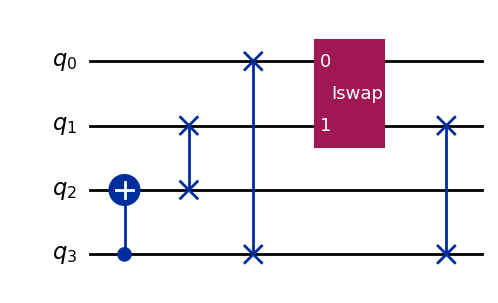

In [6]:
# Generate a random two-qubit circuit
qc = random_two_qubit_circuit(4, 5)

qc.draw("mpl")

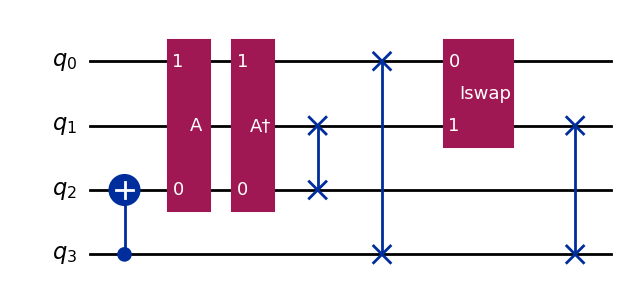

In [7]:
# Perform gate insertion
inserted_qc, B1_info, updated_er_gates = gate_insert(qc)

inserted_qc.draw("mpl")

### Gate swapping

In [8]:
def gate_swap(qc: QuantumCircuit, B1_info):
    """Perform gate swapping by replacing A† with a three-qubit unitary.

    Args:
        qc: The quantum circuit returned by gate_insert.
        B1_info: Information about gate B1 and the inserted gates.

    Returns:
        new_qc: The modified quantum circuit after gate swapping.
    """
    B1_idx = B1_info["index"]
    B1_qubits = B1_info["qubits"]
    B1_gate = B1_info["gate"]
    shared_qubit = B1_info["shared_qubit"]
    third_qubit = B1_info["third_qubit"]
    A_dag = B1_info["A_dag"]

    # Map indices back to qubits
    qubit_map = {qc.find_bit(q).index: q for q in qc.qubits}
    q1 = qubit_map[B1_qubits[0]]
    q2 = qubit_map[B1_qubits[1]]
    q3 = qubit_map[third_qubit]

    # Get the unitary matrix of B1
    B1_operator = Operator(B1_gate)
    U_B1 = B1_operator.data

    # Compute the three-qubit unitary \widetilde{A^\dagger}
    I = np.eye(2)  # Identity for a single qubit

    # Compute B1 ⊗ I
    B1_tensor_I = np.kron(U_B1, I)

    # Compute (B1 ⊗ I)^\dagger
    B1_tensor_I_dag = B1_tensor_I.conj().T

    # Compute I ⊗ A^\dagger
    I_tensor_A_dag = np.kron(I, A_dag.data)

    # Compute \widetilde{A^\dagger}
    A_dag_tilde_data = B1_tensor_I_dag @ I_tensor_A_dag @ B1_tensor_I
    A_dag_tilde = Operator(A_dag_tilde_data)

    # Create a new circuit
    new_qc = QuantumCircuit(qc.num_qubits)

    # Copy the gates up to the insertion point of A†
    insertion_point = B1_idx + 2  # B1 and A have been inserted before A†
    for instruction in qc.data[:insertion_point]:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        new_qc.append(instr, qargs, cargs)

    # Replace A† with \widetilde{A^\dagger} on qubits [q1, q2, q3]
    qubits_for_A_dag_tilde = [q1, q2, q3]
    new_qc.unitary(A_dag_tilde, qubits_for_A_dag_tilde, label="A_dag_tilde")

    # Copy the remaining gates, skipping the original A†
    for instruction in qc.data[insertion_point+1:]:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        new_qc.append(instr, qargs, cargs)

    return new_qc

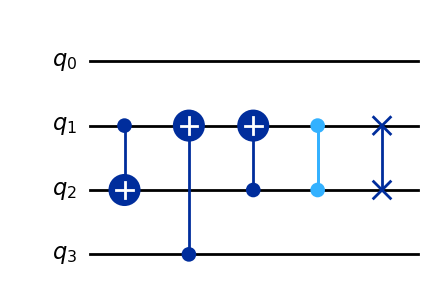

In [9]:
# Initialize an empty list to keep track of gates generated in previous ERs
previous_er_gates = []

# Generate a random two-qubit circuit
qc = random_two_qubit_circuit(4, 5)

qc.draw("mpl")

Circuit after applying ER with P_r strategy:


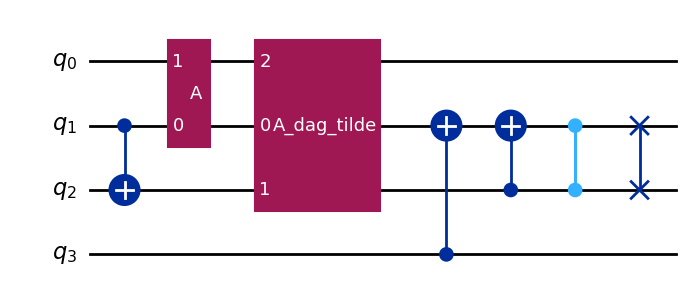

In [10]:
# Perform gate insertion using P_r strategy
inserted_qc, B1_info, previous_er_gates = gate_insert(qc, strategy='P_r', previous_er_gates=previous_er_gates)

# Perform gate swapping
final_qc = gate_swap(inserted_qc, B1_info)

print("Circuit after applying ER with P_r strategy:")
final_qc.draw("mpl")


Circuit after applying ER with P_c strategy:


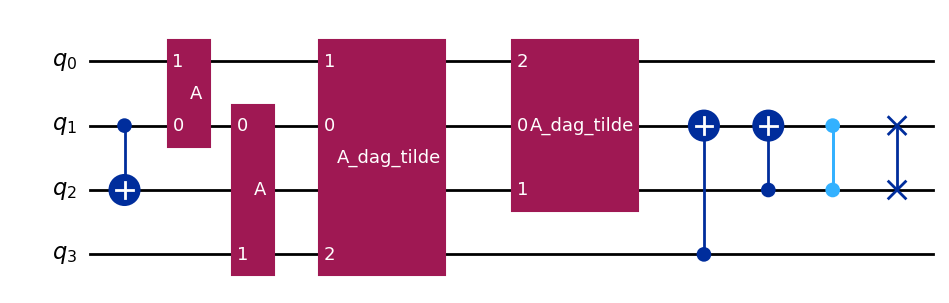

In [11]:
# Now, perform another ER using P_c strategy
inserted_qc_2, B1_info_2, previous_er_gates = gate_insert(final_qc, strategy='P_c', previous_er_gates=previous_er_gates)

# Perform gate swapping
final_qc_2 = gate_swap(inserted_qc_2, B1_info_2)

print("\nCircuit after applying ER with P_c strategy:")
final_qc_2.draw("mpl")

### Gate decomposition

In [12]:
def gate_decompose(qc: QuantumCircuit):
    """Decompose multi-qubit unitary gates into basic gates supported by the hardware.

    Args:
        qc: The quantum circuit containing multi-qubit unitaries.

    Returns:
        new_qc: The decomposed quantum circuit.
    """
    # Decompose the circuit using Qiskit's built-in transpiler
    # We set basis gates to decompose into CNOT and single-qubit rotations
    basis_gates = ["u3", "cx"]
    new_qc = transpile(qc, basis_gates=basis_gates, optimization_level=0)
    return new_qc

### Gate synthesis

In [13]:
def gate_synthesize(qc: QuantumCircuit):
    """Optimize the decomposed circuit to reduce gate count or depth.

    Args:
        qc: The decomposed quantum circuit.

    Returns:
        optimized_qc: The optimized quantum circuit.
    """
    # Optimize the circuit using Qiskit's transpiler with a higher optimization level
    optimized_qc = transpile(qc, optimization_level=3)
    return optimized_qc

### Applying ER

Final circuit after applying the complete ER:


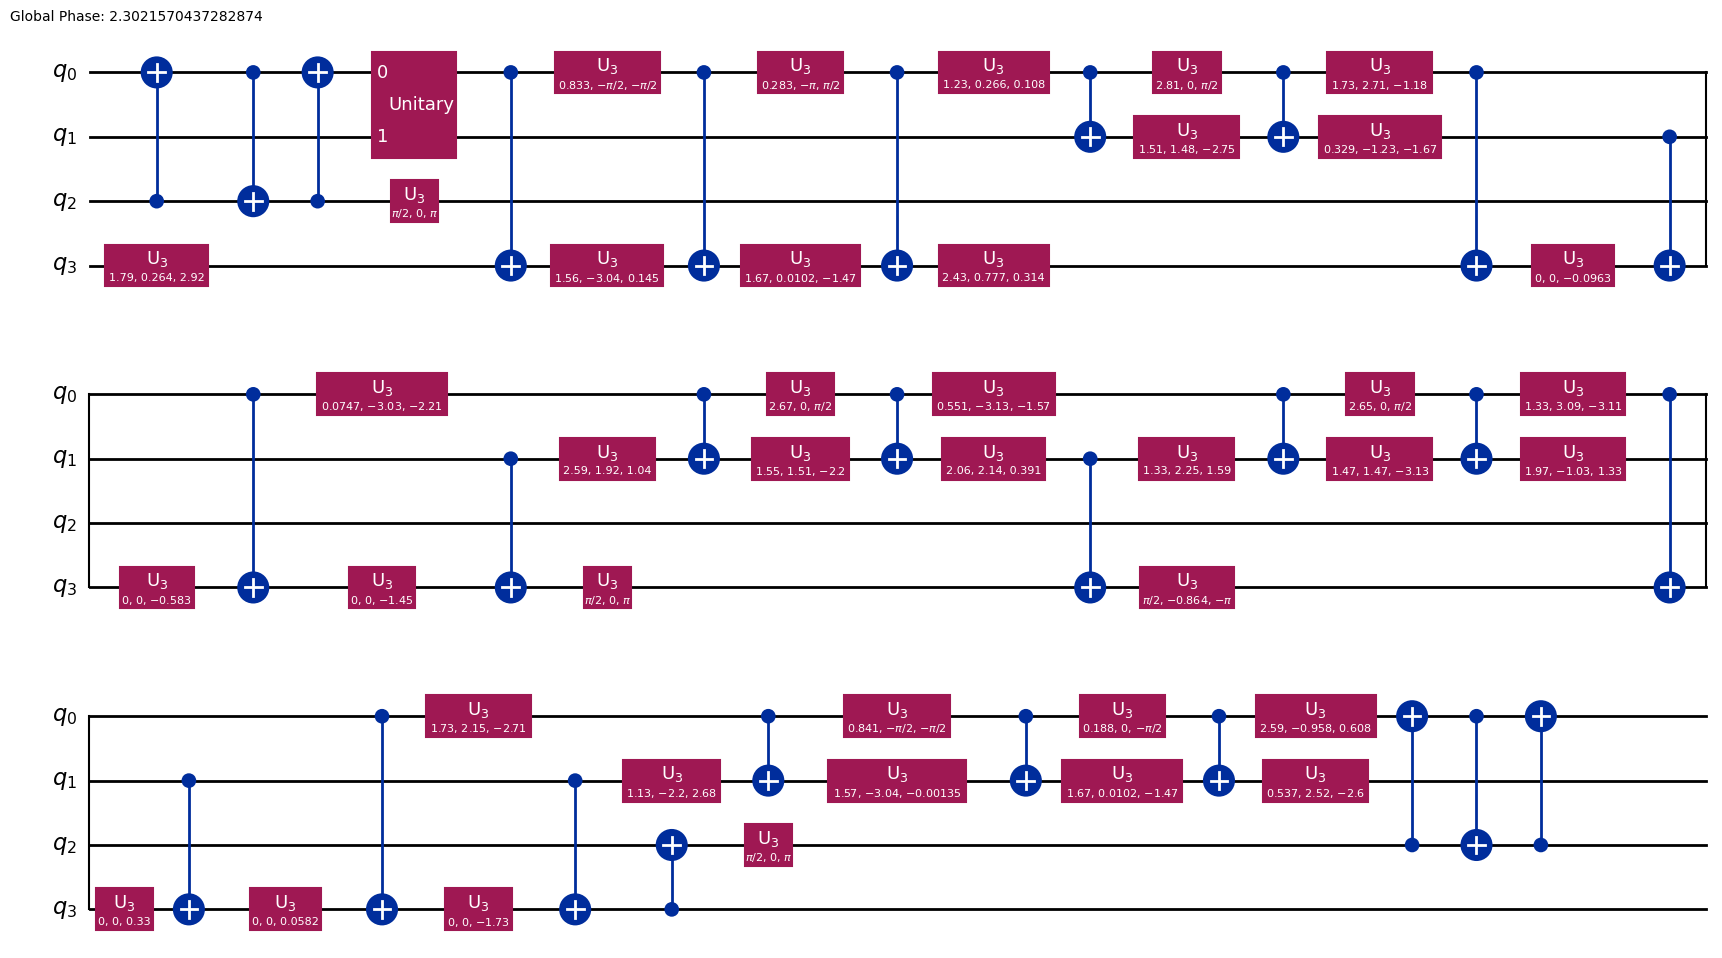

In [14]:
# Initialize an empty list to keep track of gates generated in previous ERs
previous_er_gates = []

# Generate a random two-qubit circuit
qc = random_two_qubit_circuit(4, 5)

# Perform gate insertion using P_r strategy
inserted_qc, B1_info, previous_er_gates = gate_insert(
    qc, strategy="P_r", previous_er_gates=previous_er_gates
)

# Perform gate swapping
swapped_qc = gate_swap(inserted_qc, B1_info)

# Perform gate decomposition
decomposed_qc = gate_decompose(swapped_qc)

# Perform gate synthesis (optimization)
final_qc = gate_synthesize(decomposed_qc)

print("Final circuit after applying the complete ER:")
final_qc.draw("mpl")